## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = list(sorted(set(text)))
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
idx_to_token = dict(enumerate(tokens))

# dict <char>:<index>
token_to_idx = {value: idx for idx, value in idx_to_token.items()}

In [6]:
assert len(tokens) == len(token_to_idx), "dictionaries must have same size"
assert len(tokens) == len(idx_to_token), "dictionaries must have same size"

num_tokens = len(tokens)
for i in range(num_tokens):
    assert token_to_idx[tokens[i]] == i, "token identifier must be it's position in tokens list"
    assert idx_to_token[i] == tokens[i], "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [7]:
import numpy as np
import torch
import torchsummary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [8]:
encoded = torch.tensor([token_to_idx[char] for char in text])
encoded.shape

torch.Size([100225])

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [9]:
def get_batches(data, batch_size, seq_length):
  bsize_total = batch_size * seq_length
  num_batches = data.shape[0] // bsize_total
  data = data[:bsize_total * num_batches]
  data = data.reshape((batch_size, -1))

  for i in range(0, data.shape[1], seq_length):
    x = data[:, i:i+seq_length]
    y = torch.zeros_like(x)
    try:
      last_chars = data[:, i + seq_length]
    except IndexError:
      last_chars = data[:, 0]
    y[:, :-1], y[:, -1] = x[:, 1:], last_chars
    yield x, y

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
class CharRNNLoop(nn.Module):
  def __init__(self, num_tokens=len(tokens), emb_size=len(tokens), rnn_num_units=64):
    super(self.__class__, self).__init__()
    self.num_units = rnn_num_units
    self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
    self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
      
  def forward(self, x, h_prev):
    rnn_out, h_next = self.rnn(x, h_prev)
    out = rnn_out.contiguous().view((-1, self.num_units))
    out = self.hid_to_logits(out)
    return out, h_next
  
  def init_hidden(self, batch_size):
    return torch.zeros((1, batch_size, self.num_units), requires_grad=True)

In [11]:
def train(net, data=encoded, n_epochs=10, batch_size=16, seq_length=100, lr=1e-3, is_lstm=False):
  net.train()
  opt = optim.Adam(net.parameters(), lr=lr)
  loss_func = nn.CrossEntropyLoss()

  loss_history = []

  for epoch in range(n_epochs):
    h = net.init_hidden(batch_size)
    for x, y in get_batches(data, batch_size, seq_length):
      input = F.one_hot(x, len(tokens)).to(torch.float32).to(device)
      target = y.to(device)
      if is_lstm:
        h = tuple([state.data.to(device) for state in h])
      else:
        h = h.data.to(device)
      opt.zero_grad()
      output, h = net(input, h)
      loss = loss_func(output, target.view(batch_size * seq_length).long())
      loss.backward()
      opt.step()
      loss_history.append(loss.item())
    print(f"Epoch: {epoch}, loss: {loss_history[-1]: .3}")
  return loss_history

In [12]:
model = CharRNNLoop().to(device)
ret = train(model, n_epochs=50, lr=0.007)
len(ret)

Epoch: 0, loss:  2.35
Epoch: 1, loss:  2.15
Epoch: 2, loss:  2.05
Epoch: 3, loss:  1.98
Epoch: 4, loss:  1.93
Epoch: 5, loss:  1.89
Epoch: 6, loss:  1.87
Epoch: 7, loss:  1.84
Epoch: 8, loss:  1.81
Epoch: 9, loss:  1.79
Epoch: 10, loss:  1.78
Epoch: 11, loss:  1.76
Epoch: 12, loss:  1.75
Epoch: 13, loss:  1.73
Epoch: 14, loss:  1.72
Epoch: 15, loss:  1.71
Epoch: 16, loss:  1.7
Epoch: 17, loss:  1.69
Epoch: 18, loss:  1.68
Epoch: 19, loss:  1.67
Epoch: 20, loss:  1.67
Epoch: 21, loss:  1.66
Epoch: 22, loss:  1.66
Epoch: 23, loss:  1.65
Epoch: 24, loss:  1.64
Epoch: 25, loss:  1.64
Epoch: 26, loss:  1.63
Epoch: 27, loss:  1.63
Epoch: 28, loss:  1.63
Epoch: 29, loss:  1.63
Epoch: 30, loss:  1.62
Epoch: 31, loss:  1.62
Epoch: 32, loss:  1.62
Epoch: 33, loss:  1.62
Epoch: 34, loss:  1.62
Epoch: 35, loss:  1.62
Epoch: 36, loss:  1.61
Epoch: 37, loss:  1.61
Epoch: 38, loss:  1.61
Epoch: 39, loss:  1.61
Epoch: 40, loss:  1.61
Epoch: 41, loss:  1.6
Epoch: 42, loss:  1.6
Epoch: 43, loss:  1.6
Ep

3100

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1, style="whitegrid")

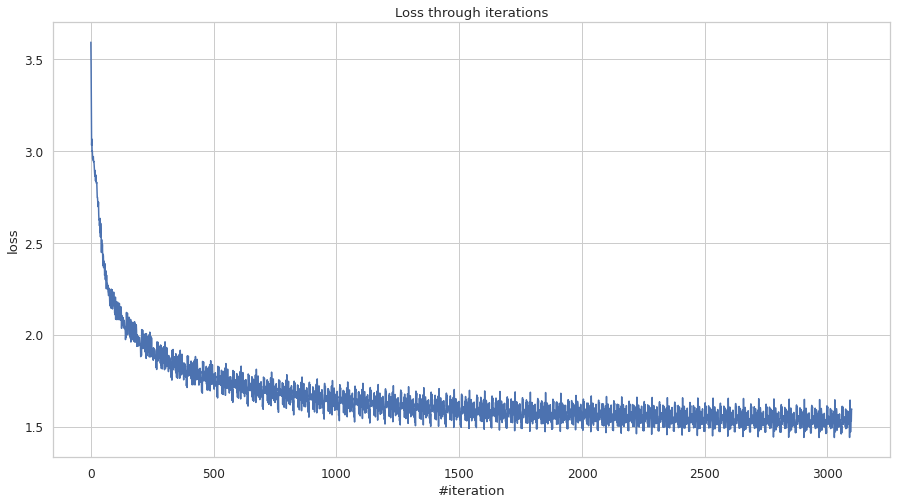

In [14]:
plt.figure(figsize=(15, 8))
sns.lineplot(x=np.arange(len(ret)), y=ret)
plt.title("Loss through iterations")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.show()

In [15]:
def predict(net, char, h=None, temperature=0.1, is_lstm=False):
  x = torch.tensor([[token_to_idx[char]]])
  x = F.one_hot(x, len(tokens)).float()
  inputs = x.to(device)
  
  if is_lstm:
    h = tuple([state.data.to(device) for state in h])
  else:
    h = h.data.to(device)
  out, h = net(inputs, h)

  p = F.softmax(out / temperature, dim=-1).data.to(device)
  
  top_ch = torch.arange(len(tokens))
  p = p.numpy().squeeze()
  char = np.random.choice(top_ch, p=p/p.sum())
  
  return idx_to_token[char], h

In [16]:
def sample(net, size, prime='Il', temperature=0.1, is_lstm=False):
  net.eval() # eval mode
  prime = prime.lower()
  chars = [ch for ch in prime]
  h = net.init_hidden(1)
  for ch in prime:
      char, h = predict(net, ch, h, temperature=temperature, is_lstm=is_lstm)
  chars.append(char)
  for ii in range(size):
      char, h = predict(net, chars[-1], h, temperature=temperature, is_lstm=is_lstm)
      chars.append(char)
  return ''.join(chars)

In [17]:
print(sample(model, 500, prime=' Hello', temperature=0.5))

 hellore from serven in this for my heart the sweet and the present and thee the eye doth place may thou art thou fair the world the fair the with far the thought and to the and the enet the be so west be in thee best the sainted and that the praise thy seage thee and net the with this fair in the chant in eyes the fault or this time, my senst thou art is his from my self did bring in thee and conties,
  and in this for the still the the winkn, and in the the heart the the true the beauty be my some, b


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [18]:
class CharLSTMLoop(nn.Module):
  def __init__(self, num_tokens=len(tokens), emb_size=len(tokens), rnn_num_units=64):
    super(self.__class__, self).__init__()
    self.num_units = rnn_num_units
    self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
    self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

  def forward(self, x, h_prev):
    rnn_out, h_next = self.rnn(x, h_prev)
    out = rnn_out.contiguous().view((-1, self.num_units))
    out = self.hid_to_logits(out)
    return out, h_next
  
  def init_hidden(self, batch_size):
    return (torch.zeros((1, batch_size, self.num_units), requires_grad=True),
            torch.zeros((1, batch_size, self.num_units), requires_grad=True))

In [19]:
lstm_model = CharLSTMLoop().to(device)
lstm_ret = train(lstm_model, n_epochs=20, lr=0.007, is_lstm=True)
len(lstm_ret)

Epoch: 0, loss:  2.62
Epoch: 1, loss:  2.24
Epoch: 2, loss:  2.1
Epoch: 3, loss:  2.0
Epoch: 4, loss:  1.93
Epoch: 5, loss:  1.88
Epoch: 6, loss:  1.84
Epoch: 7, loss:  1.8
Epoch: 8, loss:  1.76
Epoch: 9, loss:  1.73
Epoch: 10, loss:  1.71
Epoch: 11, loss:  1.68
Epoch: 12, loss:  1.66
Epoch: 13, loss:  1.65
Epoch: 14, loss:  1.64
Epoch: 15, loss:  1.63
Epoch: 16, loss:  1.63
Epoch: 17, loss:  1.61
Epoch: 18, loss:  1.59
Epoch: 19, loss:  1.58


1240

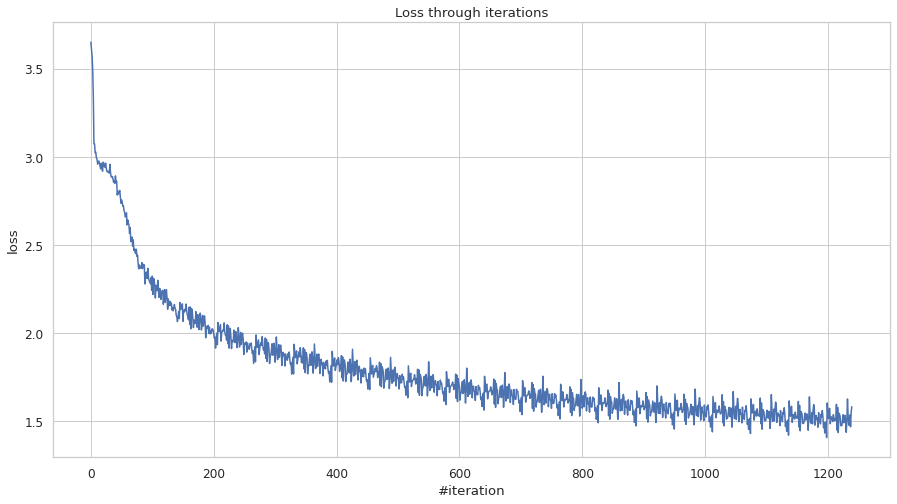

In [20]:
plt.figure(figsize=(15, 8))
sns.lineplot(x=np.arange(len(lstm_ret)), y=lstm_ret)
plt.title("Loss through iterations")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.show()

__OBSERVATION:__ After 20 epochs RNN got 1.67 loss, and LSTM got slightly less, 1.58.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [21]:
temps = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temps:
  print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(temperature = {temp})~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  print(sample(lstm_model, 500, prime=' Hello', temperature=temp, is_lstm=True))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(temperature = 0.1)~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 hellon in thee,
    the fort and the stringted the strings of thee,
    that i an the stringt the stringted steel
  the farth the stringted and thee steel
  the far the strence strengle thee thee doth lie,
    the fort a tome the strence strange thee thee steet
  and thee the strence strengle thee thee thee,
    that i am the sweet the strence strange,
    that i am thou art the strence strange,
  and the stringt of the stringted thee doth lie,
    that the stringted the stringted and thee doth lie,
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(temperature = 0.2)~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 hellon in thee.

  xxviii

  the stringt the stare the strence the receates,
  and thee the stringt of the stringted,
  and thee the earth the stronger thee thee doth lie,
    that in the stronger i to the string,
  and the stringted the strearted a tome steet,
  and thee thee thou ar

__Conclusion:__ 
1. In LSTM we can see that it can also remember the structure of the text and generates almost poetic styled text. Also, it acquires a more reasonable context from the symbolic sequences. However, as our tokens are symbols, not words, all models are generating too stupid text. Well ,RNN is too weak for generating a poetic styled text, as it cannot remember the last `\n` symbol.
2. As for the LSTM itself, with low temperature we are getting the most common words from the original text. But by increasing the temperature we are lossing english :), and getting a random symbol set. However, in all temperatures, the poetic style is not changing which means that some reasonable infomration is still retrieved from the data.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [30]:
rnn_poet = "./rnn_poet.pth"
lstm_poet = "./lstm_poet.pth"

with open(rnn_poet, 'wb') as f:
  torch.save(model, f)

with open(lstm_poet, 'wb') as f:
  torch.save(lstm_model, f)

In [31]:
with open(rnn_poet, 'rb') as f:
  rnn_net = torch.load(f)
  rnn_net.eval()
  print(sample(rnn_net, 500, prime=' Hello', temperature=0.5))

 hellower in my part,
  and what waster far that the will and that that heart love the sun my heart the reast,
  and thou take and the world and thou do doth love and friend age:
    and and thou bear the heart that is brand and fair factent and my daken'd that my heart this none, or hate in the death's be the conth maken's art this compare still doth make all the beart which sweet beauty thought men thou lick with thou art in breath heart the wasten you doth that muse of heart heart thee happerter tim


In [33]:
with open(lstm_poet, 'rb') as f:
  lstm_net = torch.load(f)
  lstm_net.eval()
  print(sample(lstm_net, 500, prime=' Hello', temperature=0.5, is_lstm=True))

 hellon,
  when the care my the stringties a preceat;
  and have show thee thee the east in thee for thee:
    that heart that sweet thou thou how when thee dost fair,
    and thee thine fair the care me is time,
  and my never i that in the parted,
  and for thee you my self to heir doth plear,
  but is thou doth with that to thy sweet sight
  and contains and beauty of thee troad
  and for thee that such were thee hold,
  that i the some are proud this not so worl
  and the remair that and heart for 


STATE OF THE ART ARTIFICIALY TALENTED POETS! :)

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)